## Librerias

In [ ]:
import pandas as pd
import math
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.algorithms import unique

## Funciones

### Funciones para generar el arbol id3

In [ ]:
def contar_clases(atributo_decision_, clases_):
    cont_clases_ = np.zeros((len(clases_)))
    for n, c in enumerate(clases_):
        cont_clases_[n] = int(np.sum(atributo_decision_ == c))
    return cont_clases_

In [ ]:
def calcular_entropia(cont_clases_):
    entropia_decision_ = 0
    total = int(sum(cont_clases_))
    for d in cont_clases_:
        if d == 0: entropia_decision_ += 0
        else: entropia_decision_ -= (d/total)*np.log2(d/total)
    return entropia_decision_

In [ ]:
def ganancia_atributo(x_, y_, cont_clases_, entropia_, clases_):
    Total_ = int(sum(cont_clases_))
    ganancias_ = {}
    for a in x_.columns:
        ganancias_[a] = 0
        observaciones = x_[a].unique()
        for o in observaciones:
            y_a_o_ = y_.loc[x_[a] == o]
            cont_clases_y_a_o_ = contar_clases(y_a_o_, clases_)
            entropia_a_o_ = calcular_entropia(cont_clases_y_a_o_)
            total_ = int(sum(cont_clases_y_a_o_))
            ganancias_[a] += (total_/Total_) * entropia_a_o_
        ganancias_[a] = entropia_ - ganancias_[a]
    return ganancias_

In [ ]:
def nodo_raiz(ganancias_):
    raiz_ = max(ganancias_.items(), key=operator.itemgetter(1))[0]
    entropia_r_ = ganancias_[raiz_]
    return raiz_, entropia_r_

In [ ]:
def nodos_intermedios(x_, y_, atributo_, obs_):
    subx_ = []
    suby_ = []
    for o in obs_:
        pos_coinciden_ = x_[atributo_] == o
        subx_.append(x_.loc[pos_coinciden_])
        suby_.append(y_.loc[pos_coinciden_])
    return subx_, suby_

In [ ]:
def fin_rama(y_fr_, obs_):
    hoja_ = 0
    clase_fr_ = 0
    n = len(y_fr_)
    for o in obs_:
        coincidencias_ = int(np.sum(y_fr_ == o))
        if coincidencias_ == n:
            hoja_ = 1
            clase_fr_ = o
    return hoja_, clase_fr_

In [ ]:
def arbol_id3(x_, y_, clases_, arbol_):
    conteo_clases = contar_clases(y_, clases_)
    entropia_decision_ = calcular_entropia(conteo_clases)
    ganancias_ = ganancia_atributo(x_, y_, conteo_clases, 
                                   entropia_decision_, clases_)
    nodo_raiz_, entropia_raiz_ = nodo_raiz(ganancias_)
    arbol_[nodo_raiz_] = {}
    ramas_ = x_[nodo_raiz_].unique()
    sub_x_, sub_y_ = nodos_intermedios(x_, y_, nodo_raiz_, ramas_)
    for r, sx, sy in zip(ramas_, sub_x_, sub_y_):
        arbol_[nodo_raiz_][r] = {}
        hoja_, clase_f_ = fin_rama(sy, clases_)
        if hoja_ == 1:
            arbol_[nodo_raiz_][r] = clase_f_
        else:
            arbol_id3(sx, sy, clases_, arbol_[nodo_raiz_][r])
    return arbol_

### Función para separa la base de datos en entrenamiento y prueba

In [ ]:
def split_80_20(datos_, etiquetas_):
  n_ = len(datos_)
  indices_ = np.arange(n_)
  np.random.shuffle(indices_)
  lim = int(n_ * 0.80) + 1
  x_train_ = datos_.loc[indices_[0:lim]]
  x_test_ = datos_.loc[indices_[lim:]]
  y_train_ = etiquetas_.loc[indices_[0:lim]]
  y_test_ = etiquetas_.loc[indices_[lim:]]
  return x_train_, x_test_, y_train_, y_test_

### Funciones evaluar algoritmo

In [ ]:
def exactitud(y_calculada_, y_real_):
  coincidencias = np.equal(y_calculada_, y_real_)
  total_coin_ = np.sum(coincidencias)
  porcentaje_ = (total_coin_ / len(y_calculada_))
  return porcentaje_

In [ ]:
def precision(y_clas_, y_real_):
  TP = 0
  FP = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 'positive': TP += 1
    elif (r != c) and r == 'negative': FP += 1
  pre_ = TP / (TP + FP)
  return pre_

In [ ]:
def sensitividad(y_clas_, y_real_):
  TP_ = 0
  FN_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 'positive': TP_ += 1
    elif (r != c) and r == 'positive': FN_ += 1
  sens_ = TP_ / (TP_ + FN_)
  return sens_

In [ ]:
def especificidad(y_clas_, y_real_):
  TN_ = 0
  FP_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 'negative': TN_ += 1
    elif (r != c) and r == 'negative': FP_ += 1
  esp_ = TN_ / (TN_ + FP_)
  return esp_

In [ ]:
def puntaje_F1(y_clas_, y_real_):
  prec_ = precision(y_clas_, y_real_)
  sens_ = sensitividad(y_clas_, y_real_)
  pf1_ = 2 * ((prec_ * sens_) / (prec_ + sens_))
  return pf1_

## Base de datos

La base de datos se puede encontrar en:

https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bases_de_Datos/tic-tac-toe-endgame.csv')
columnas = df.columns.values

x = df[columnas[0:9]].copy()
y = df['V10']
clases = y.unique()

In [ ]:
print("Dimensión:",df.shape)
df.head()

Dimensión: (958, 10)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


In [ ]:
df.isnull().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
dtype: int64

In [ ]:
elementos_columnas = {}
for c in columnas:
  elementos_columnas[c] = df[c].unique()

elementos_columnas

{'V1': array(['x', 'o', 'b'], dtype=object),
 'V10': array(['positive', 'negative'], dtype=object),
 'V2': array(['x', 'o', 'b'], dtype=object),
 'V3': array(['x', 'o', 'b'], dtype=object),
 'V4': array(['x', 'o', 'b'], dtype=object),
 'V5': array(['o', 'b', 'x'], dtype=object),
 'V6': array(['o', 'b', 'x'], dtype=object),
 'V7': array(['x', 'o', 'b'], dtype=object),
 'V8': array(['o', 'x', 'b'], dtype=object),
 'V9': array(['o', 'x', 'b'], dtype=object)}

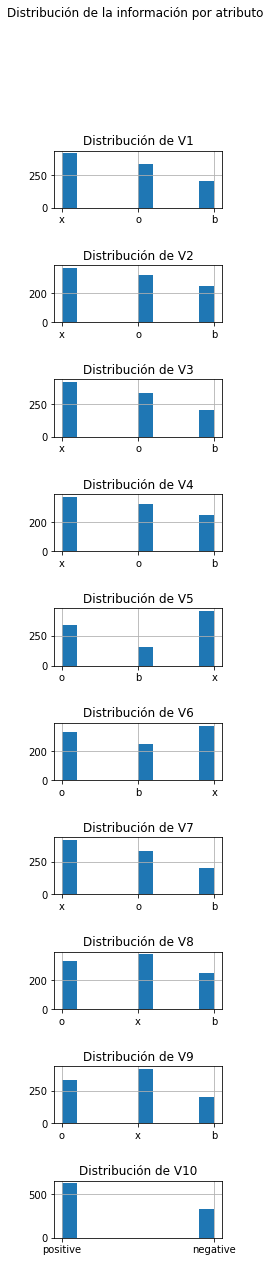

In [ ]:
fig, axs = plt.subplots(df.shape[1], 1, figsize = (3,20))
fig.suptitle('Distribución de la información por atributo.')
plt.subplots_adjust(hspace = 1)
for i, c in enumerate(columnas):
  dist_datos = df[c]
  axs[i].set_title(f'Distribución de {c}.')
  axs[i].hist(dist_datos)
  axs[i].grid(True)

In [ ]:
x_train, x_test, y_train, y_test = split_80_20(x, y)

## Entrenamineto de id3

In [ ]:
arbol_gato = {}
arbol_gato = arbol_id3(x_train, y_train, clases, arbol_gato)

In [ ]:
arbol_gato

{'V5': {'b': {'V7': {'b': {'V3': {'o': 'negative', 'x': 'positive'}},
    'o': {'V3': {'b': 'negative',
      'o': 'negative',
      'x': {'V9': {'b': {'V1': {'o': 'negative', 'x': 'positive'}},
        'o': {'V8': {'b': 'positive',
          'o': 'negative',
          'x': {'V1': {'o': 'negative', 'x': 'positive'}}}},
        'x': {'V6': {'b': {'V1': {'o': 'negative', 'x': 'positive'}},
          'o': {'V1': {'o': 'negative', 'x': 'positive'}},
          'x': 'positive'}}}}}},
    'x': {'V3': {'b': 'positive',
      'o': {'V1': {'b': {'V9': {'o': 'negative', 'x': 'positive'}},
        'o': {'V4': {'b': 'positive', 'o': 'positive', 'x': 'negative'}},
        'x': 'positive'}},
      'x': 'positive'}}}},
  'o': {'V1': {'b': {'V9': {'b': 'negative',
      'o': 'negative',
      'x': {'V7': {'b': {'V4': {'b': 'positive',
          'o': {'V2': {'b': 'negative', 'o': 'positive', 'x': 'negative'}},
          'x': 'negative'}},
        'o': {'V3': {'o': 'negative',
          'x': {'V6': {'o':

### Función para evaluar id3

In [ ]:
def clasificar_gato(x_clasificar):
  V1 = x_clasificar['V1']
  V2 = x_clasificar['V2']
  V3 = x_clasificar['V3']
  V4 = x_clasificar['V4']
  V5 = x_clasificar['V5']
  V6 = x_clasificar['V6']
  V7 = x_clasificar['V7']
  V8 = x_clasificar['V8']
  V9 = x_clasificar['V9']
  resultado = 'No se econtro'

  if V5 == 'b':
      if V3 == 'b':
          if V7 == 'o': resultado = 'negative'
          elif V7 == 'x': resultado = 'positive'

      elif V3 == 'o':
          if V7 == 'b': resultado = 'negative'
          elif V7 == 'o': resultado = 'negative'
          elif V7 == 'x':
              if V1 == 'b':
                  if V9 == 'o': resultado = 'negative'
                  elif V9 == 'x': resultado = 'positive'

              elif V1 == 'o':
                  if V2 == 'b': resultado = 'positive'
                  elif V2 == 'o': resultado = 'negative'
                  elif V2 == 'x':
                      if V4 == 'b': resultado = 'positive'
                      elif V4 == 'x': resultado = 'negative'

              elif V1 == 'x':
                  if V4 == 'b':
                      if V2 == 'b': resultado = 'negative'
                      elif V2 == 'o': resultado = 'positive'

                  elif V4 == 'o':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o': resultado = 'positive'
                      elif V2 == 'x': resultado = 'negative'
                  
                  elif V4 == 'x': resultado = 'positive'

      elif V3 == 'x':
          if V7 == 'b': resultado = 'positive'
          elif V7 == 'o':
              if V9 == 'b':
                  if V1 == 'o': resultado = 'negative'
                  elif V1 == 'x': resultado = 'positive'

              elif V9 == 'o':
                  if V8 == 'b': resultado = 'positive'
                  elif V8 == 'o': resultado = 'negative'
                  elif V8 == 'x':
                      if V1 == 'o': resultado = 'negative'
                      elif V1 == 'x': resultado = 'positive'

              elif V9 == 'x':
                  if V6 == 'b':
                      if V1 == 'o': resultado = 'negative'
                      elif V1 == 'x': resultado = 'positive'

                  elif V6 == 'o':
                      if V1 == 'o': resultado = 'negative'
                      elif V1 == 'x': resultado = 'positive'

                  elif V6 == 'x': resultado = 'positive'

          elif V7 == 'x': resultado = 'positive'

  elif V5 == 'o':
      if V9 == 'b':
          if V1 == 'b': resultado = 'negative'
          elif V1 == 'o': resultado = 'negative'
          elif V1 == 'x':
              if V6 == 'b':
                  if V2 == 'b': resultado = 'positive'
                  elif V2 == 'o':
                      if V3 == 'b': resultado = 'positive'
                      elif V3 == 'o': resultado = 'positive'
                      elif V3 == 'x': resultado = 'negative'

                  elif V2 == 'x':
                      if V3 == 'o':
                          if V7 == 'o': resultado = 'negative'
                          elif V7 == 'x': resultado = 'positive'
                   
                      elif V3 == 'x': resultado = 'positive'

              elif V6 == 'o':
                  if V4 == 'b': resultado = 'positive'
                  elif V4 == 'o': resultado = 'negative'
                  elif V4 == 'x':
                      if V3 == 'b': resultado = 'positive'
                      elif V3 == 'o':
                          if V2 == 'b': resultado = 'positive'
                          elif V2 == 'x': resultado = 'negative'
                          
                      elif V3 == 'x': resultado = 'positive'

              elif V6 == 'x':
                  if V8 == 'b':
                      if V2 == 'b': resultado = 'negative'
                      elif V2 == 'o': resultado = 'positive'

                  elif V8 == 'o':
                      if V2 == 'o': resultado = 'negative'
                      elif V2 == 'x':
                          if V3 == 'o': resultado = 'negative'
                          elif V3 == 'x': resultado = 'positive'

                  elif V8 == 'x': resultado = 'negative'

      elif V9 == 'o':
          if V1 == 'b': resultado = 'negative'
          elif V1 == 'o': resultado = 'negative'
          elif V1 == 'x':
              if V6 == 'b':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o':
                      if V7 == 'o': resultado = 'negative'
                      elif V7 == 'x': resultado = 'positive'
                      
                  elif V3 == 'x': resultado = 'positive'

              elif V6 == 'o':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o': resultado = 'negative'
                  elif V3 == 'x': resultado = 'positive'

              elif V6 == 'x':
                  if V7 == 'b':
                      if V2 == 'o': resultado = 'negative'
                      elif V2 == 'x': resultado = 'positive'

                  elif V7 == 'o': resultado = 'negative'
                  elif V7 == 'x':
                      if V4 == 'b': resultado = 'negative'

                      elif V4 == 'o':
                          if V3 == 'o': resultado = 'negative'
                          elif V3 == 'x': resultado = 'positive'

                      elif V4 == 'x': resultado = 'positive'
                          
      elif V9 == 'x':
          if V3 == 'b':
              if V7 == 'b': resultado = 'negative'
              elif V7 == 'o': resultado = 'negative'
              elif V7 == 'x':
                  if V8 == 'b':
                      if V1 == 'b': resultado = 'negative'
                      elif V1 == 'x': resultado = 'positive'

                  elif V8 == 'o':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o': resultado = 'negative'
                      elif V2 == 'x': resultado = 'negative'

                  elif V8 == 'x': resultado = 'positive'

          elif V3 == 'o':
              if V7 == 'b': resultado = 'negative'
              elif V7 == 'o': resultado = 'negative'
              elif V7 == 'x':
                  if V8 == 'b':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o': resultado = 'negative'
                      elif V2 == 'x': resultado = 'negative'

                  elif V8 == 'o':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o': resultado = 'negative'
                      elif V2 == 'x': resultado = 'negative'

                  elif V8 == 'x': resultado = 'positive'

          elif V3 == 'x':
              if V6 == 'b':
                  if V2 == 'b': resultado = 'positive'
                  elif V2 == 'o':
                      if V8 == 'o': resultado = 'negative'
                      elif V8 == 'x': resultado = 'positive'
                      
                  elif V2 == 'x': resultado = 'positive'

              elif V6 == 'o':
                  if V4 == 'b':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o':
                          if V1 == 'b': resultado = 'positive'
                          elif V1 == 'x': resultado = 'negative'

                      elif V2 == 'x': resultado = 'positive'

                  elif V4 == 'o': resultado = 'negative'
                  elif V4 == 'x':
                      if V1 == 'b': resultado = 'negative'
                      elif V1 == 'o':
                          if V2 == 'o': resultado = 'positive'
                          elif V2 == 'x': resultado = 'negative'

                      elif V1 == 'x':
                          if V2 == 'o': resultado = 'negative'
                          elif V2 == 'x': resultado = 'positive'

              elif V6 == 'x': resultado = 'positive'
          
  elif V5 == 'x':
      if V1 == 'b':
          if V4 == 'b':
              if V2 == 'b':
                  if V3 == 'o': resultado = 'negative'
                  elif V3 == 'x': resultado = 'positive'

              elif V2 == 'o': resultado = 'positive'
              elif V2 == 'x': resultado = 'positive'

          elif V4 == 'o': resultado = 'positive'

          elif V4 == 'x':
              if V6 == 'b':
                  if V2 == 'b': resultado = 'negative'
                  elif V2 == 'o': resultado = 'positive'
                  elif V2 == 'x':
                      if V3 == 'b': resultado = 'negative'
                      elif V3 == 'o': resultado = 'positive'

              elif V6 == 'o':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o': resultado = 'negative'
                  elif V3 == 'x':
                      if V2 == 'b': resultado = 'positive'
                      elif V2 == 'o': resultado = 'positive'
                      elif V2 == 'x': resultado = 'negative'

              elif V6 == 'x': resultado = 'positive'

      elif V1 == 'o':
          if V7 == 'b':
              if V2 == 'b': resultado = 'positive'
              elif V2 == 'o':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o': resultado = 'negative'
                  elif V3 == 'x': resultado = 'positive'

              elif V2 == 'x': resultado = 'positive'
              
          elif V7 == 'o':
              if V4 == 'b': resultado = 'positive'
              elif V4 == 'o': resultado = 'negative'
              elif V4 == 'x':
                  if V6 == 'b':
                      if V3 == 'b': resultado = 'positive'
                      elif V3 == 'o':
                          if V2 == 'o': resultado = 'negative'
                          elif V2 == 'x': resultado = 'positive'

                      elif V3 == 'x': resultado = 'negative'

                  elif V6 == 'o':
                      if V8 == 'o': resultado = 'negative'
                      elif V8 == 'x': resultado = 'positive'

                  elif V6 == 'x': resultado = 'positive'

          elif V7 == 'x':
              if V3 == 'b': resultado = 'positive'
              elif V3 == 'o':
                  if V2 == 'b':
                      if V9 == 'b': resultado = 'positive'
                      elif V9 == 'o': resultado = 'negative'
                      elif V9 == 'x': resultado = 'positive'

                  elif V2 == 'o': resultado = 'negative'
                  elif V2 == 'x':
                      if V8 == 'b': resultado = 'negative'
                      elif V8 == 'o': resultado = 'negative'
                      elif V8 == 'x': resultado = 'positive'

              elif V3 == 'x': resultado = 'positive'

      elif V1 == 'x':
          if V9 == 'b': resultado = 'positive'

          elif V9 == 'o':
              if V7 == 'b':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o':
                      if V6 == 'b': resultado = 'positive'
                      elif V6 == 'o': resultado = 'negative'
                      elif V6 == 'x': resultado = 'positive'

                  elif V3 == 'x': resultado = 'positive'
              
              elif V7 == 'o':
                  if V8 == 'b':
                      if V6 == 'b': resultado = 'positive'
                      elif V6 == 'o': resultado = 'negative'
                      elif V6 == 'x': resultado = 'positive'
                      
                  elif V8 == 'o': resultado = 'negative'
                  elif V8 == 'x':
                      if V2 == 'b': resultado = 'negative'
                      elif V2 == 'o':
                          if V3 == 'o': resultado = 'positive'
                          elif V3 == 'x': resultado = 'negative'
                          
                      elif V2 == 'x': resultado = 'positive'
    
              elif V7 == 'x':
                  if V3 == 'b': resultado = 'positive'
                  elif V3 == 'o':
                      if V4 == 'b': resultado = 'negative'                          
                      elif V4 == 'o': resultado = 'negative'
                      elif V4 == 'x': resultado = 'positive'

                  elif V3 == 'x': resultado = 'positive'

          elif V9 == 'x': resultado = 'positive'
          
  return resultado


In [ ]:
def clasificar_id3(x_):
  indices_ = x_.index
  clasificaciones_ = []
  for i in indices_:
    clasifica_ = x_.loc[i]
    resultado_i = clasificar_gato(clasifica_)
    clasificaciones_.append(resultado_i)
  return clasificaciones_

## Clasificar y evaluar árbol

Evaluar entrenamiento

In [ ]:
y_clasificada_ent = clasificar_id3(x_train)

In [ ]:
exactitud_id3_ent = exactitud(y_clasificada_ent, y_train)
precision_id3_ent = precision(y_clasificada_ent, y_train)
sensitividad_id3_ent = sensitividad(y_clasificada_ent, y_train)
especificidad_id3_ent = especificidad(y_clasificada_ent, y_train)
puntaje_F1_id3_ent = puntaje_F1(y_clasificada_ent, y_train)

In [ ]:
print(f'''Exactitud: {exactitud_id3_ent}
Precisión: {precision_id3_ent}
Sensitividad: {sensitividad_id3_ent}
Especificidad: {especificidad_id3_ent}
Puntaje F1: {puntaje_F1_id3_ent}''')

Exactitud: 1.0
Precisión: 1.0
Sensitividad: 1.0
Especificidad: 1.0
Puntaje F1: 1.0


Evaluar prueba

In [ ]:
y_clasificada = clasificar_id3(x_test)

In [ ]:
exactitud_id3 = exactitud(y_clasificada, y_test)
precision_id3 = precision(y_clasificada, y_test)
sensitividad_id3 = sensitividad(y_clasificada, y_test)
especificidad_id3 = especificidad(y_clasificada, y_test)
puntaje_F1_id3 = puntaje_F1(y_clasificada, y_test)

In [ ]:
print(f'''Exactitud: {exactitud_id3}
Precisión: {precision_id3}
Sensitividad: {sensitividad_id3}
Especificidad: {especificidad_id3}
Puntaje F1: {puntaje_F1_id3}''')

Exactitud: 0.9685863874345549
Precisión: 0.957983193277311
Sensitividad: 0.991304347826087
Especificidad: 0.9342105263157895
Puntaje F1: 0.9743589743589743
